## <font color=blue> HiCAT example usage  </font>
####  Machine Learning and Bioinformatics (MLBI) Lab @ DKU, 2022.07.27 <br>

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import cm

## import HiCAT

In [2]:
from MarkerCount.hicat import HiCAT, show_summary 
from MarkerCount.hicat import plot_marker_expression_profile

https://github.com/combio-dku


## Load single-cell data

In [3]:
file = 'Melanoma_5K_rev'
adata_t = sc.read_h5ad(file + '.h5ad')
adata_t

AnnData object with n_obs × n_vars = 4513 × 23684
    obs: 'tumor', 'malignant', 'cell_type', 'broad_cell_type', 'sample_name', 'celltype', 'celltype_major', 'celltype_minor', 'cluster', 'HiCAT_subset', 'HiCAT_minor', 'HiCAT_major', 'scSorter_major', 'scSorter_minor', 'Garnett_major', 'Garnett_minor', 'SCINA_major', 'SCINA_minor', 'DigitalCellSorter_subset', 'DigitalCellSorter_minor', 'DigitalCellSorter_major', 'scType_major', 'scType_minor', 'scCatch_major', 'scCatch_minor', 'pid', 'scType_subset', 'scCatch_subset', 'SCINA_subset', 'Garnett_subset', 'scSorter_subset'
    var: 'gene_name'
    uns: 'HiCAT_result', 'HiCAT_summary'

In [4]:
X = adata_t.to_df()

### Run HiCAT

In [10]:
## Marker file to use
mkr_file = 'cell_markers_rndsystems.tsv'

# df_pred, summary = \
#     HiCAT( X, marker_file = mkr_file, log_transformed = False,
#                    Clustering_algo = 'lv', Clustering_resolution = 1, 
#                    Target_FPR = 0.05, pval_th = 0.05,
#                    target_cell_types = [], ## all in the db
#                    minor_types_to_exclude = [], N_neighbors_minor = 21,
#                    N_neighbors_subset = 1, cycling_cell = False, 
#                    verbose = False )

target_tissues = [] # ['Immune', 'General']
target_cell_types = ['T cell', 'B cell', 'Myeloid cell', 'Fibroblast',
                     'Epithelial cell', 'Endothelial cell', 
                     'Mast cell', 'Smooth muscle cell'] 
to_exclude = [] 

df_pred, summary = \
    HiCAT( X, mkr_file, log_transformed = False,
           target_tissues = target_tissues, target_cell_types = target_cell_types, 
               minor_types_to_exclude = to_exclude, mkr_selector = '100000', 
               N_neighbors_minor = 31, N_neighbors_subset = 1,  
               Clustering_algo = 'lv', Clustering_resolution = 1, 
               Clustering_base = 'pca', N_pca_components = 15, 
               cbc_cutoff = 0.01, Target_FPR = 0.05, pval_th = 0.05,
               cycling_cell = False, copy_X = False, verbose = False )


HiCAT running ...P4.C0...M10....M18.....S6. done. (39)


## Compare performance (Major-type annotation)

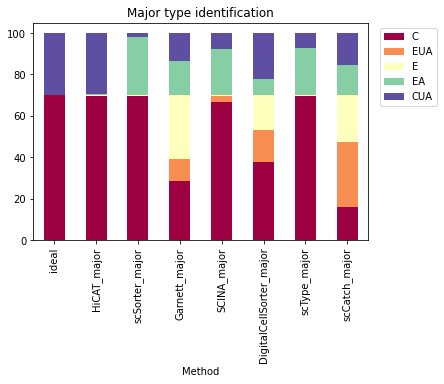

In [11]:
from MarkerCount.hicat import get_markers_major_type, get_markers_cell_type, get_perf_ext

## Get target major cell-types 
mkr_lst_pos, mkr_lst_neg = get_markers_major_type(mkr_file)
target_cell_types = list(mkr_lst_pos.keys())

## Columns to select from adata_t.obs
cols = ['celltype', 'HiCAT', 'scSorter', 'Garnett', 
            'SCINA', 'DigitalCellSorter', 'scType', 'scCatch']
cols_sel = [c + '_major' for c in cols]

## Get columns & set target cell-types
df_pred_all = adata_t.obs[cols_sel].astype(str)
df_pred_all['target_cell_types'] = ','.join(target_cell_types)

## Get performances
df_perf = get_perf_ext( df_pred_all, cell_types_not_consider = ['Unknown'], 
                                    truth = cols_sel[0])

ax = df_perf.plot( x = 'Method', kind = 'bar', stacked = True, title = 'Major type identification', \
                       cmap = cm.get_cmap('Spectral'), legend = False )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # , title = 'legend')
plt.show()

## Compare performance (Minor-type annotation)

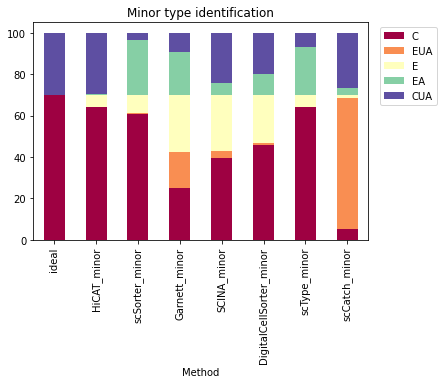

In [12]:
## Get target minor cell-types 
mkr_lst_pos, mkr_lst_neg = get_markers_cell_type(mkr_file)
target_cell_types = list(mkr_lst_pos.keys())

## Columns to select from adata_t.obs
cols = ['celltype', 'HiCAT', 'scSorter', 'Garnett', 
            'SCINA', 'DigitalCellSorter', 'scType', 'scCatch']
cols_sel = [c + '_minor' for c in cols]

## Get columns & set target cell-types
df_pred_all = adata_t.obs[cols_sel].astype(str)
df_pred_all['target_cell_types'] = ','.join(target_cell_types)

## Get performances
df_perf = get_perf_ext( df_pred_all, cell_types_not_consider = ['Unknown'], 
                                    truth = cols_sel[0])

ax = df_perf.plot( x = 'Method', kind = 'bar', stacked = True, title = 'Minor type identification', \
                       cmap = cm.get_cmap('Spectral'), legend = False )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left') # , title = 'legend')
plt.show()

## Check UMAP

In [13]:
## Normalize and log-transform
sc.pp.normalize_total(adata_t, target_sum=1e4)
sc.pp.log1p(adata_t)
sc.pp.highly_variable_genes(adata_t, n_top_genes = 2000) 
sc.pp.scale(adata_t, max_value=10)

N_pca = 15
sc.tl.pca(adata_t, svd_solver='arpack', n_comps = N_pca, use_highly_variable = True)
sc.pp.neighbors(adata_t, n_neighbors=10, n_pcs=N_pca)
sc.tl.leiden(adata_t, resolution = 1)
sc.tl.umap(adata_t)   

2022-08-20 16:04:24.303361: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-20 16:04:24.306656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/syoon/Programs/boost/lib:
2022-08-20 16:04:24.306674: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


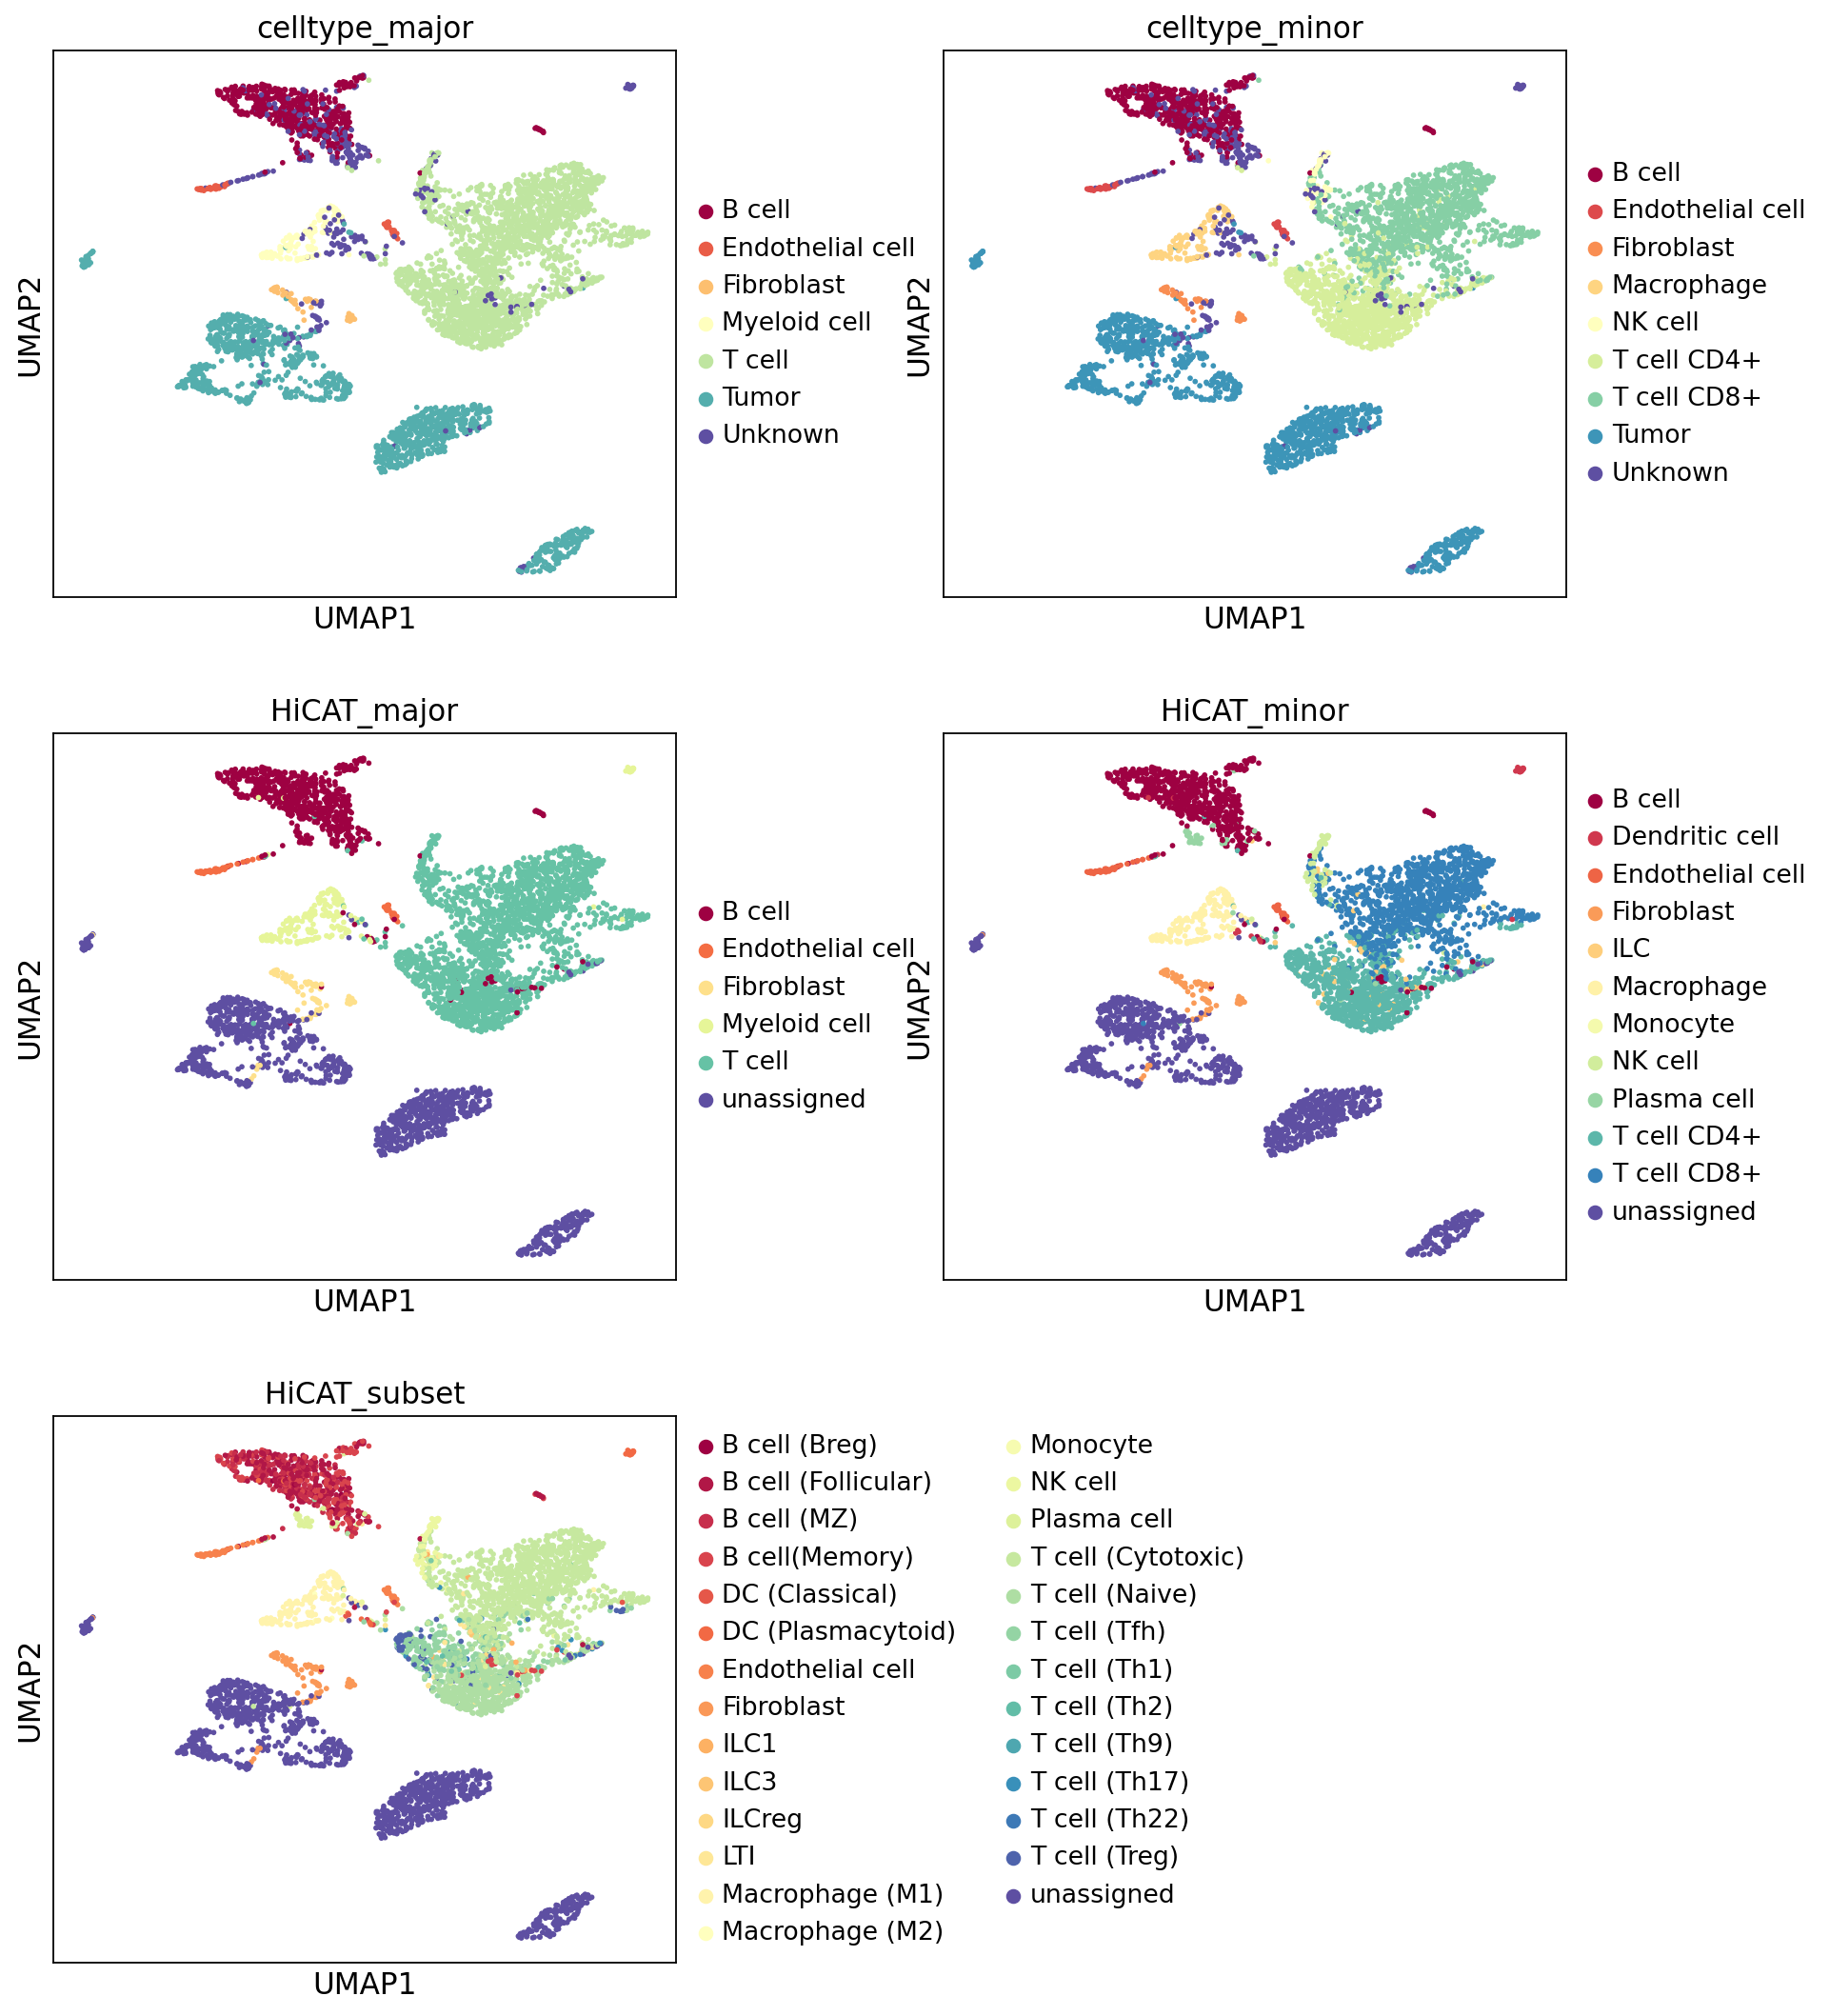

In [14]:
c_target = ['celltype_major', 'celltype_minor',
            'HiCAT_major', 'HiCAT_minor', 'HiCAT_subset'] # , 

sc.settings.set_figure_params(figsize=(5, 5), dpi=80, facecolor='white')
sc.pl.umap(adata_t, color=c_target, wspace = 0.3, \
           legend_fontsize = 12, title = c_target, ncols = 2, 
           palette = 'Spectral') 

## Check HiCAT summary

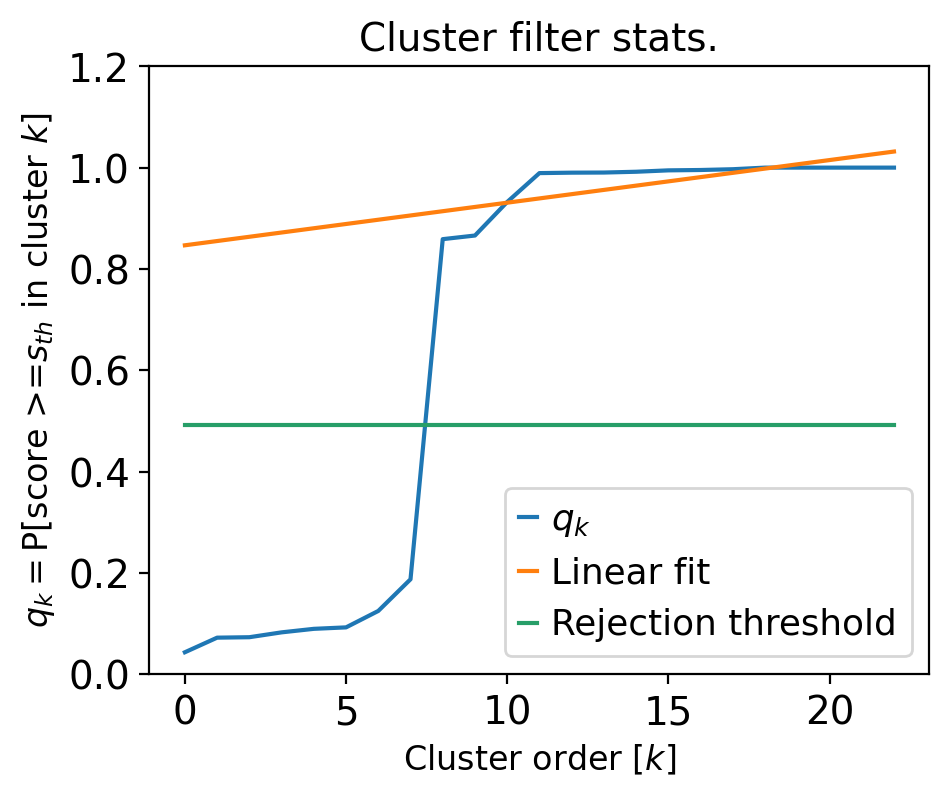

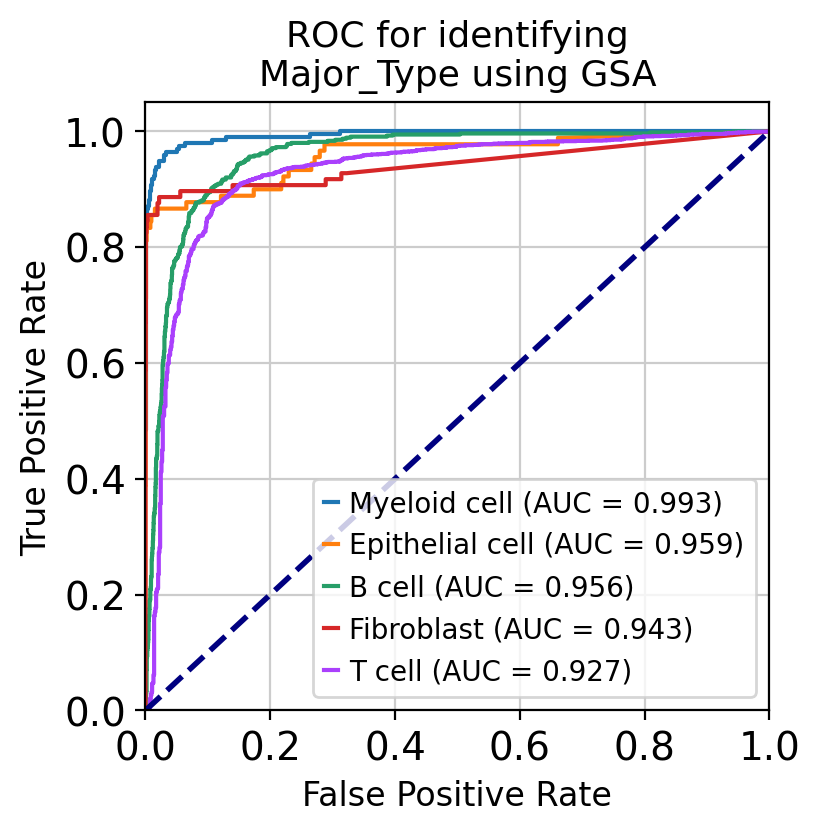

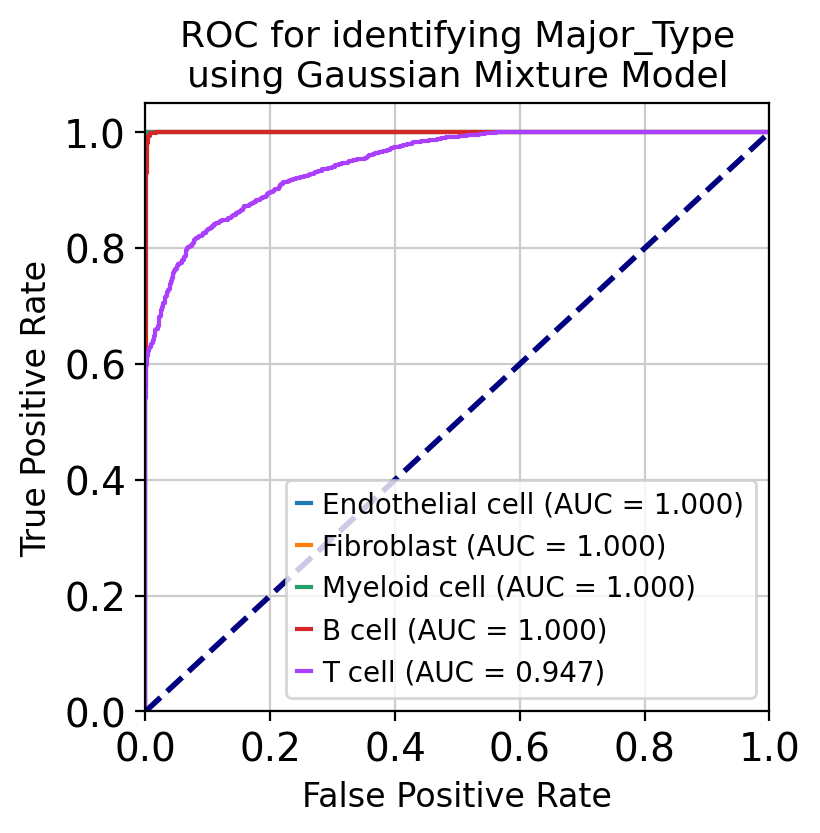

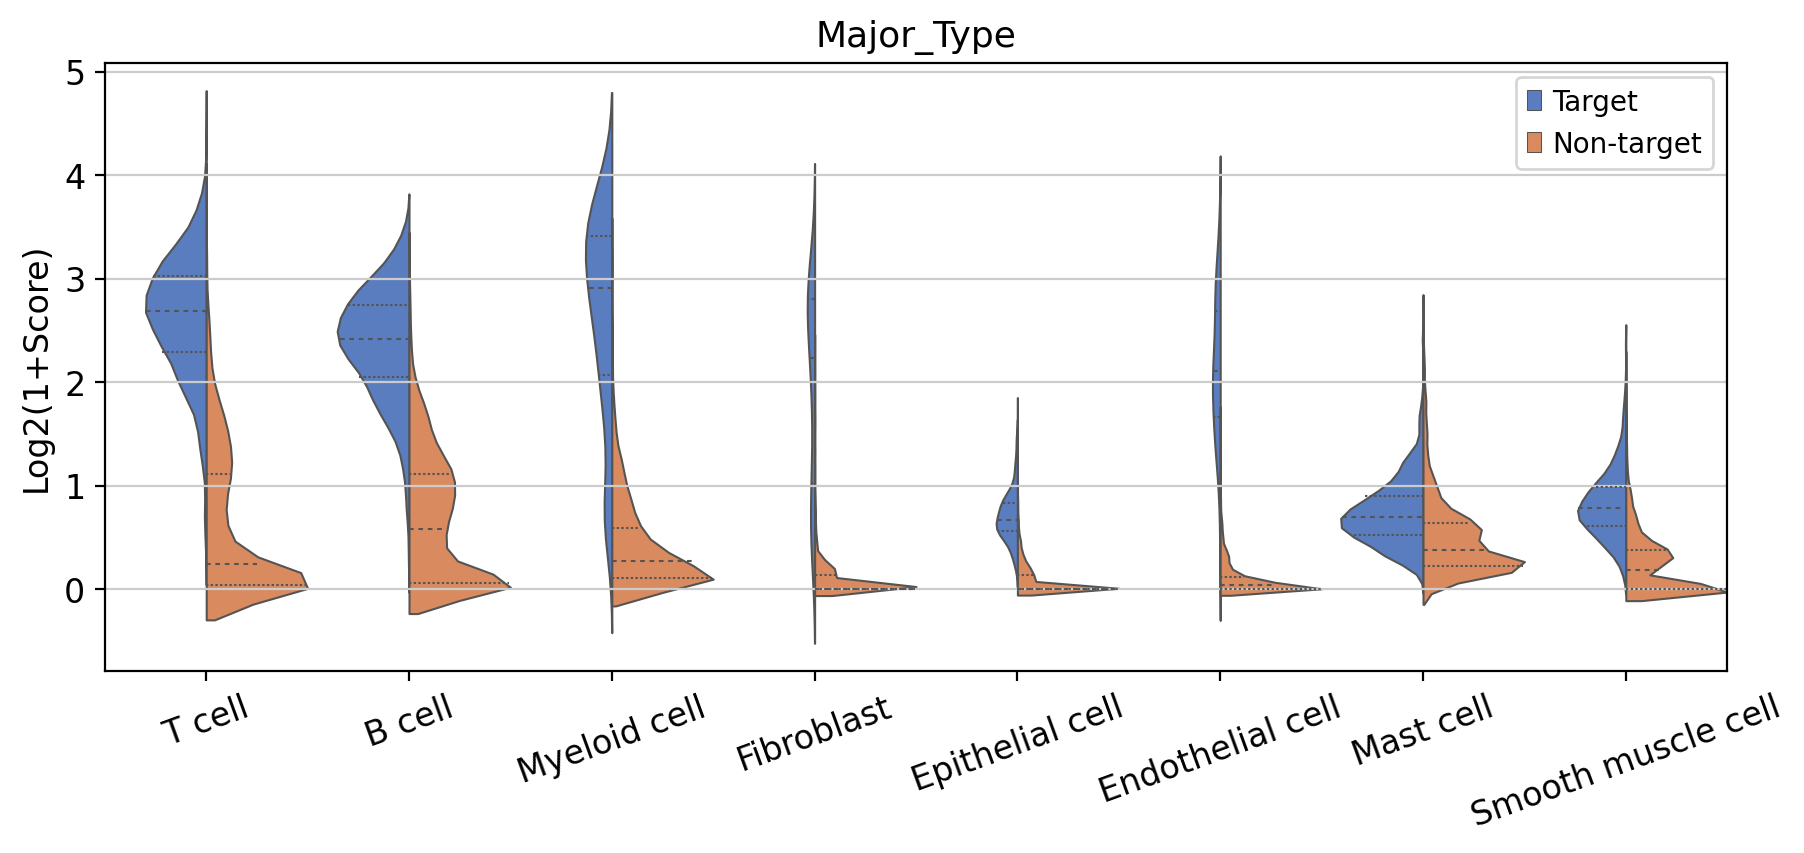

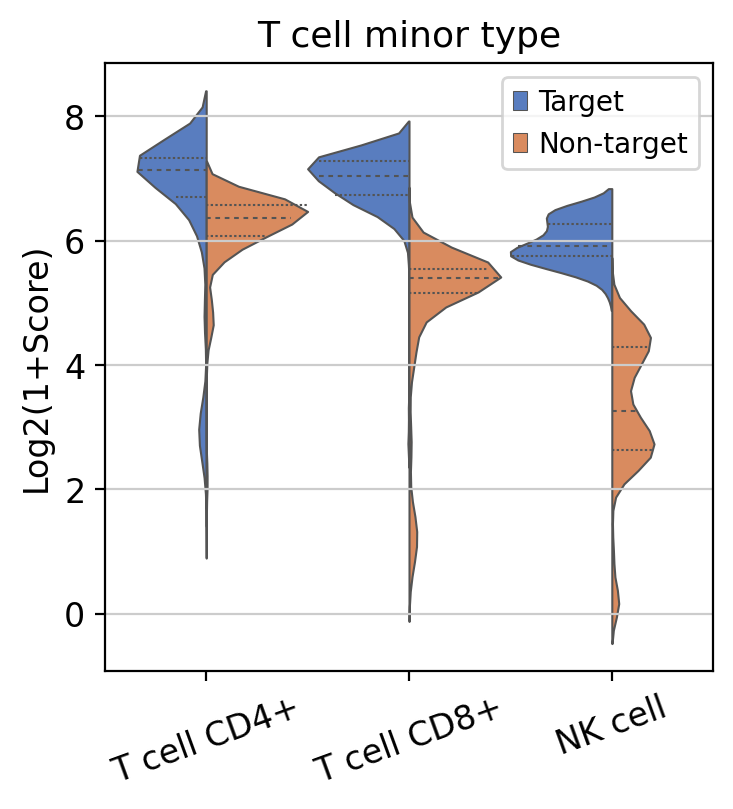

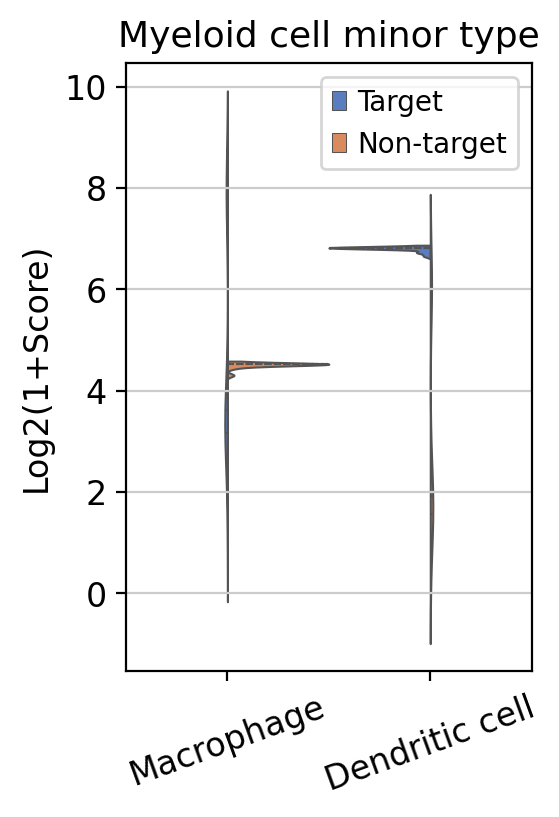

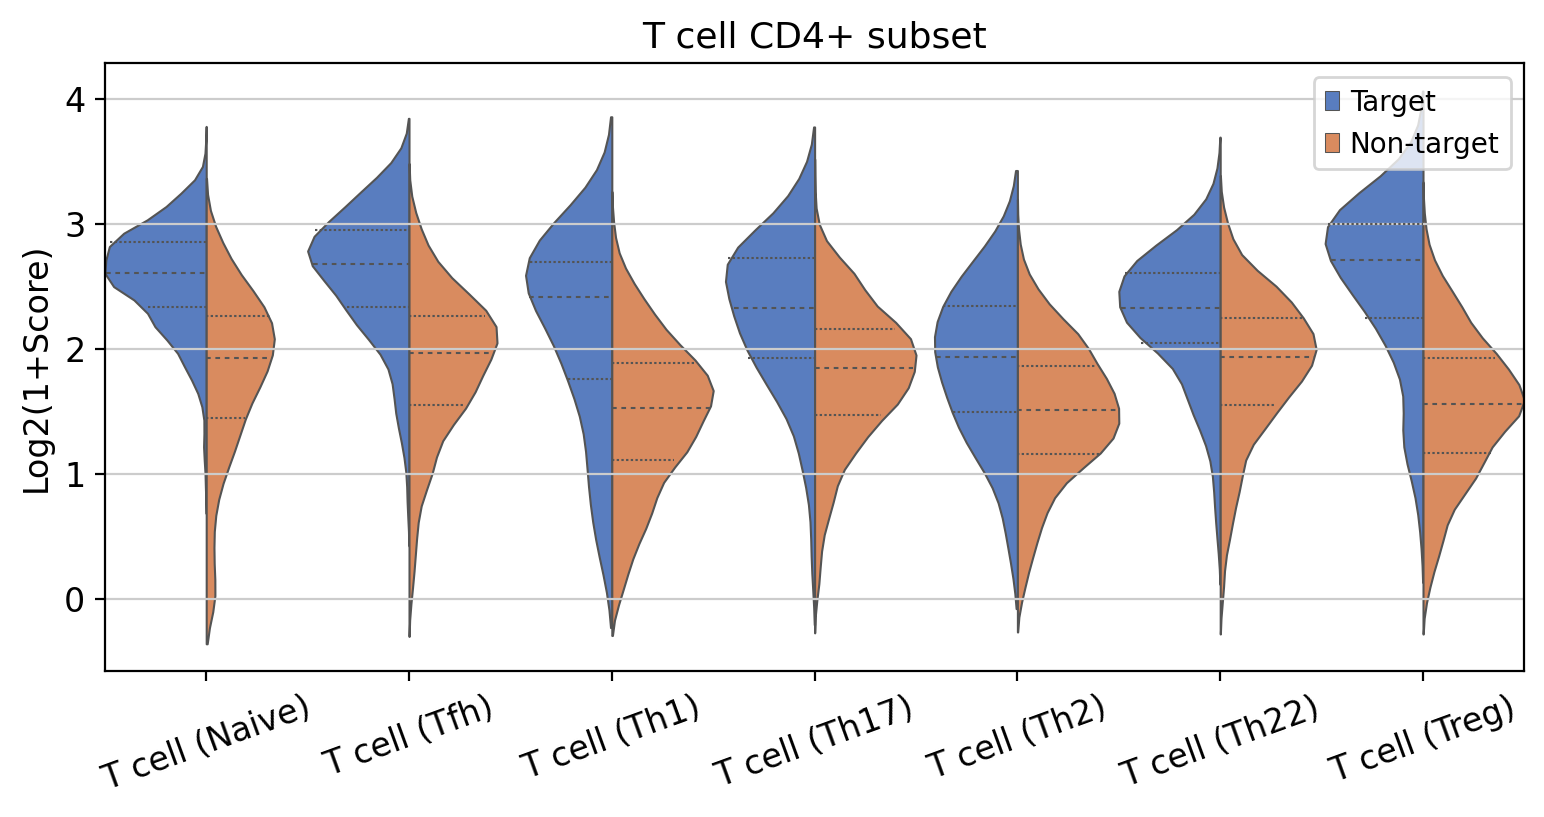

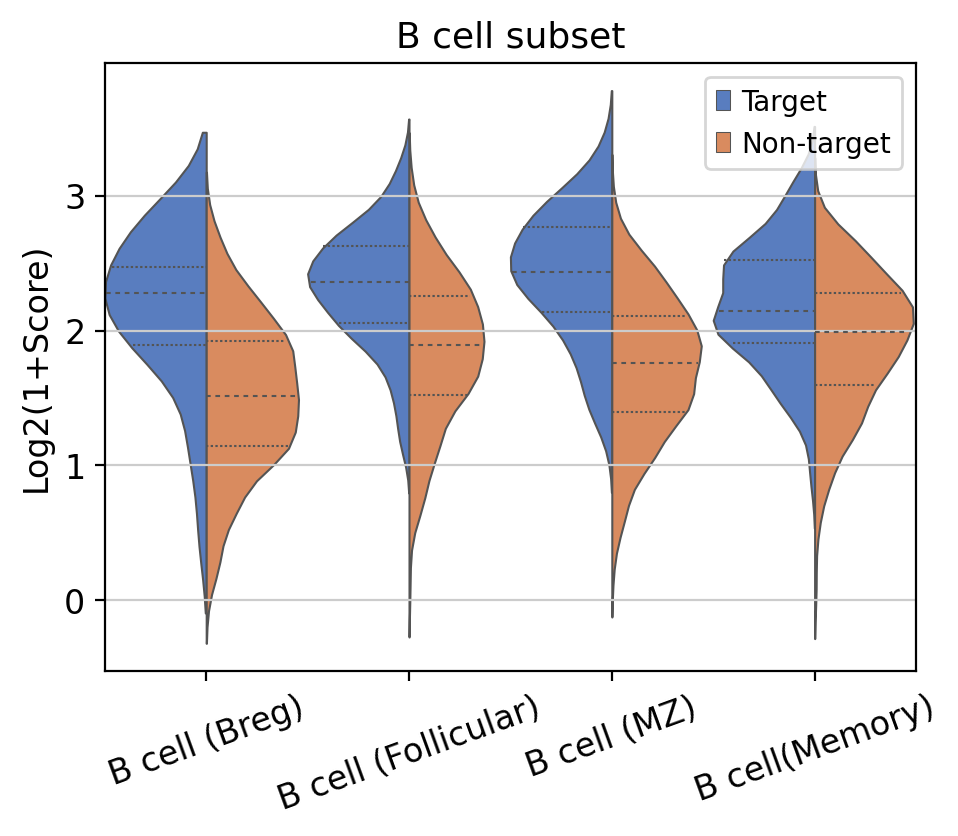

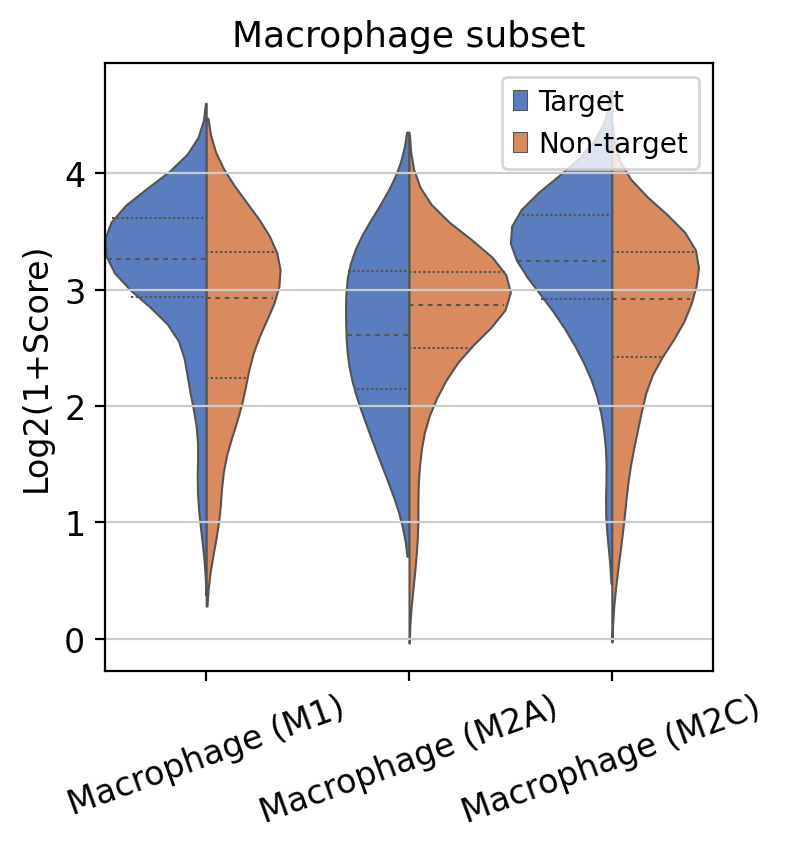

In [15]:
auc_lst = show_summary(df_pred, summary)